# Image Classification with larger CNN

The goal of this exercise is to program a slightly larger CNN that incorporates some of the ideas that have been presented in the class. We use CIFAR-100, which is a bit more challenging than the MNIST data set, but not so much. It contains 50000 images that are labelled into 100 fine-grained classes of 20 more coarse grained classes. In order to make the task a mit more complicated we will use the fine grained classes.

The dataset is build into keras.

In [2]:
import keras
import keras.datasets
import keras.datasets.cifar100
import keras.utils
import keras.optimizers
import numpy as np

import matplotlib.pyplot as plt

print(keras.__version__)

2.11.0


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

/var/folders/7l/x2mh194s2_306h2021f8m6940000gn/T/ipykernel_3589/3472643319.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(y_train[index]))


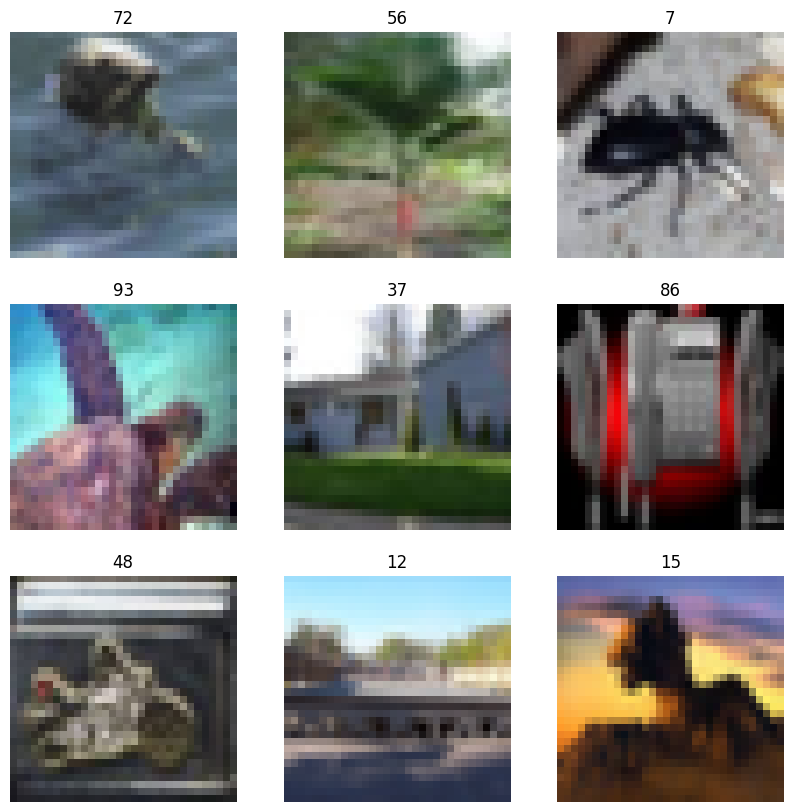

In [4]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(50000)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_train[index]).astype("uint8"))
    plt.title(int(y_train[index]))
    plt.axis("off")

In [5]:
num_classes = 100
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# ResNet-style model with skip connections (Exercise 1) + Batch Normalization
def build_model():
    inp = keras.Input(shape=(32, 32, 3))

    weight_decay = 1e-4  # L2 regularization strength

    def residual(x, filters, stride=1):
        shortcut = x
        # Conv -> BN -> ReLU
        y = keras.layers.Conv2D(
            filters, 3, strides=stride, padding='same', use_bias=False,
            kernel_regularizer=keras.regularizers.l2(weight_decay)
        )(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation('relu')(y)
        # Conv -> BN
        y = keras.layers.Conv2D(
            filters, 3, padding='same', use_bias=False,
            kernel_regularizer=keras.regularizers.l2(weight_decay)
        )(y)
        y = keras.layers.BatchNormalization()(y)
        # projection on shortcut when shape changes
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = keras.layers.Conv2D(
                filters, 1, strides=stride, padding='same', use_bias=False,
                kernel_regularizer=keras.regularizers.l2(weight_decay)
            )(shortcut)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        out = keras.layers.Add()([y, shortcut])
        out = keras.layers.Activation('relu')(out)
        return out

    # Stem: Conv -> BN -> ReLU
    x = keras.layers.Conv2D(
        32, 3, padding='same', use_bias=False,
        kernel_regularizer=keras.regularizers.l2(weight_decay)
    )(inp)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # stage 1
    x = residual(x, 32)
    x = residual(x, 32)
    # stage 2 (downsample)
    x = residual(x, 64, stride=2)
    x = residual(x, 64)
    # stage 3 (downsample)
    x = residual(x, 128, stride=2)
    x = residual(x, 128)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(100, activation='softmax',
                           kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

    return keras.Model(inp, x)

In [8]:
model = build_model()

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 32, 32, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 32, 32, 32)   0           ['batch_normalization_15[0]

In [10]:
batch_size = 128
epochs = 5
opt = keras.optimizers.RMSprop(learning_rate=0.01)
model = build_model()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
352/352 [==============================] - 366s 1s/step - loss: 4.2449 - accuracy: 0.0692 - val_loss: 4.7735 - val_accuracy: 0.0562
Epoch 2/5
352/352 [==============================] - 342s 972ms/step - loss: 3.7119 - accuracy: 0.1549 - val_loss: 4.0400 - val_accuracy: 0.1226
Epoch 3/5
352/352 [==============================] - 353s 1s/step - loss: 3.4099 - accuracy: 0.2266 - val_loss: 3.8964 - val_accuracy: 0.1478
Epoch 4/5
352/352 [==============================] - 362s 1s/step - loss: 3.1917 - accuracy: 0.2815 - val_loss: 3.5486 - val_accuracy: 0.2270
Epoch 5/5
352/352 [==============================] - 361s 1s/step - loss: 3.0385 - accuracy: 0.3233 - val_loss: 3.8522 - val_accuracy: 0.2132


The performance is not bad, but also not so great. The best results without using additional data for convolutional neural networks is at about 70 percent.

In [11]:
print(history.history)

{'loss': [4.244863033294678, 3.711918830871582, 3.4098901748657227, 3.191676378250122, 3.038515567779541], 'accuracy': [0.06924444437026978, 0.15493333339691162, 0.22660000622272491, 0.28146666288375854, 0.32331112027168274], 'val_loss': [4.7734808921813965, 4.04000997543335, 3.8964083194732666, 3.5485661029815674, 3.852159261703491], 'val_accuracy': [0.05620000138878822, 0.1225999966263771, 0.1477999985218048, 0.22699999809265137, 0.21320000290870667]}


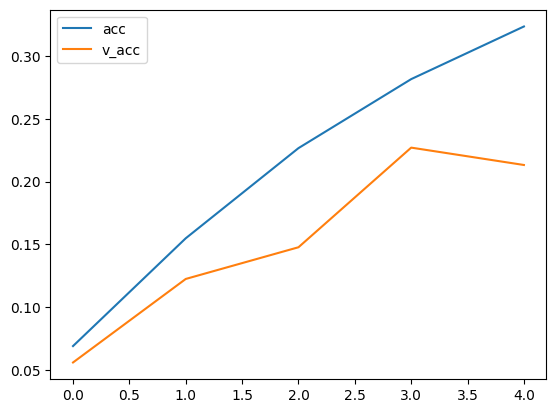

In [12]:
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='acc')
ax.plot( history.history['val_accuracy'], label='v_acc')
plt.legend()
plt.show()

## Exercise 1: Modern CNN

A *modern* CNN should have some of the features discussed in the lecture. Build a model that includes some or all of these:
- ResNet architecture with skip connections
- Batch Normalization
- L2 Regularisation
- Dropout

How does you model perform?

## Exercise 2: Monitoring

Monitoring the training is essential for long running training sessions. Include tensorboard or wandb in your training setup.

## Exercise 3: Data Augmentation (continued next lesson)

What else could be done to get better results? The dataset is quite small, so either another dataset could be used for pretraining, or data augmentation could be added....